## Goal: Build classifier to distinguish AD converters
see paper: https://www.cell.com/current-biology/pdfExtended/S0960-9822(20)30291-8

In [102]:
library(data.table)
library(tidyverse)
library(RColorBrewer)
library(reshape2)
library(gdata)
library(ggrepel)
library(DESeq2)
library(limma)


Attaching package: ‘limma’

The following object is masked from ‘package:DESeq2’:

    plotMA

The following object is masked from ‘package:BiocGenerics’:

    plotMA



In [2]:
setwd("~/coursework//cse283/project/")

In [12]:
# Read in counts table
counts.dt <- fread("./GSE136243_gene_TPM_all_samples.txt",stringsAsFactors = F)
head(counts.dt)

gene_id,gene_name,gene_biotype,C_1_01_1,AD_8_12_1,C_10_01_1,C_10_14_1,C_10_05_1,C_10_08_1,AD_11_08_1,⋯,AD_5_12_1,AD_5_13_1,AD_3_00_1,AD_3_01_1,AD_3_03_1,AD_2_01_1,AD_2_02_1,AD_2_03_1,AD_2_05_1,AD_2_07_1
ENSG00000223972,DDX11L1,transcribed_unprocessed_pseudogene,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0.00000,0.000000
ENSG00000227232,WASH7P,unprocessed_pseudogene,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,11.62609,5.503961
ENSG00000278267,MIR6859-1,miRNA,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0.00000,0.000000
ENSG00000243485,RP11-34P13.3,lincRNA,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0.00000,0.000000
ENSG00000274890,MIR1302-2,miRNA,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0.00000,0.000000
ENSG00000237613,FAM138A,lincRNA,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0.00000,0.000000


In [60]:
# get sample names and add to meta table
samp.dt <- data.frame(sample_id=colnames(counts.dt)[4:length(colnames(counts.dt))],stringsAsFactors = F) %>%
    mutate(donorID = sapply(sample_id,function(x) {
        t <- str_split(x,"_")[[1]]
        return(paste0(t[1],"_",t[2]))
    })) %>%
    mutate(year = as.numeric(sapply(sample_id,function(x) {
        t <- str_split(x,"_")[[1]]
        return(paste0("20",t[3]))
    }))) 
# head(samp.dt)

### Sample information table + year away from AD diagnosis
meta.dt <- fread("./donor_info.csv",stringsAsFactor=F) %>%
    full_join(.,samp.dt,by="donorID") %>%
    mutate(yr_since_diag = as.numeric(year)-as.numeric(Year_diagnosis))
meta.dt

sample_id,donorID,year
C_1_01_1,C_1,2001
AD_8_12_1,AD_8,2012
C_10_01_1,C_10,2001
C_10_14_1,C_10,2014
C_10_05_1,C_10,2005
C_10_08_1,C_10,2008


donorID,group,age_death,sex,braak_stage,Year_diagnosis,APOE_status,sample_id,year,yr_since_diag
N_1,control,86,M,1,NA,ε3/ε4,N_1_01_1,2001,NA
N_1,control,86,M,1,NA,ε3/ε4,N_1_05_1,2005,NA
N_1,control,86,M,1,NA,ε3/ε4,N_1_07_1,2007,NA
N_1,control,86,M,1,NA,ε3/ε4,N_1_08_1,2008,NA
N_1,control,86,M,1,NA,ε3/ε4,N_1_09_1,2009,NA
N_2,control,93,F,1,NA,ε3/ε3,N_2_00_1,2000,NA
N_2,control,93,F,1,NA,ε3/ε3,N_2_01_1,2001,NA
N_2,control,93,F,1,NA,ε3/ε3,N_2_03_1,2003,NA
N_2,control,93,F,1,NA,ε3/ε3,N_2_06_1,2006,NA
N_2,control,93,F,1,NA,ε3/ε3,N_2_08_1,2008,NA


In [61]:
# counts table into long format and join in sample info
counts.longdt <- counts.dt %>%
    melt(id.vars=c("gene_id", "gene_name", "gene_biotype"), value.name = "count", variable.name = "sample_id") %>%
    left_join(.,meta.dt,by="sample_id")
head(counts.longdt)

# Save file
fwrite(counts.longdt, "./gene_counts_sample_info.csv", row.names = F)

Warning message:
“Column `sample_id` joining factor and character vector, coercing into character vector”

gene_id,gene_name,gene_biotype,sample_id,count,donorID,group,age_death,sex,braak_stage,Year_diagnosis,APOE_status,year,yr_since_diag
ENSG00000223972,DDX11L1,transcribed_unprocessed_pseudogene,C_1_01_1,0,C_1,converter,91,F,3,2010,ε3/ε4,2001,-9
ENSG00000227232,WASH7P,unprocessed_pseudogene,C_1_01_1,0,C_1,converter,91,F,3,2010,ε3/ε4,2001,-9
ENSG00000278267,MIR6859-1,miRNA,C_1_01_1,0,C_1,converter,91,F,3,2010,ε3/ε4,2001,-9
ENSG00000243485,RP11-34P13.3,lincRNA,C_1_01_1,0,C_1,converter,91,F,3,2010,ε3/ε4,2001,-9
ENSG00000274890,MIR1302-2,miRNA,C_1_01_1,0,C_1,converter,91,F,3,2010,ε3/ε4,2001,-9
ENSG00000237613,FAM138A,lincRNA,C_1_01_1,0,C_1,converter,91,F,3,2010,ε3/ε4,2001,-9


In [107]:
meta.dt %>%
    filter(donorID == "AD_1")

donorID,group,age_death,sex,braak_stage,Year_diagnosis,APOE_status,sample_id,year,yr_since_diag
AD_1,AD,85,F,5,NA,ε3/ε4,AD_1_02_1,2002,NA
AD_1,AD,85,F,5,NA,ε3/ε4,AD_1_04_1,2004,NA
AD_1,AD,85,F,5,NA,ε3/ε4,AD_1_08_1,2008,NA
AD_1,AD,85,F,5,NA,ε3/ε4,AD_1_09_1,2009,NA
AD_1,AD,85,F,5,NA,ε3/ε4,AD_1_11_1,2011,NA
AD_1,AD,85,F,5,NA,ε3/ε4,AD_1_13_1,2013,NA


### DESEQ

In [5]:
counts.mat <- counts.dt %>%
    select(meta.dt$sample_id) %>% # ensure columns are in same order as meta dt
    as.matrix   
rownames(counts.mat) <- counts.dt$gene_id

# round counts for DESeq
counts.mat <- round(counts.mat)
head(counts.mat)

,N_1_01_1,N_1_05_1,N_1_07_1,N_1_08_1,N_1_09_1,N_2_00_1,N_2_01_1,N_2_03_1,N_2_06_1,N_2_08_1,⋯,C_10_14_1,C_10_05_1,C_10_08_1,C_10_03_1,C_10_10_1,C_10_13_1,C_11_09_1,C_11_01_1,C_11_03_1,C_11_04_1
ENSG00000223972,0,0,0,0,0,1,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000227232,0,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,26,0,0,0,0
ENSG00000278267,0,0,0,0,0,0,0,120,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000243485,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,3,0,0,8,0,0,0
ENSG00000274890,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSG00000237613,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [100]:
# ### run DESeq for condition - take a long time
# ## this needs to be a paired by patient analysis and also DE over time
# ## can try a different method but probably won't need for this project
# dds <- DESeqDataSetFromMatrix(counts.mat, colData = meta.dt, design = ~donorID + group) 

# # run DESeq for 
# start.time <- Sys.time()
# dds <- DESeq(dds)
# end.time <- Sys.time()
# time.taken <- end.time - start.time
# time.taken

In [101]:
# # pull out top genes DE between AD and controls
# res <- results(dds, contrast=c("group", "control","AD")) %>%
#     as.data.frame() %>%
#     rownames_to_column("gene_id") %>%
#     left_join(., distinct(select(counts.dt, gene_id,gene_name,gene_biotype)), by = "gene_id") %>%
#     arrange(padj)
# head(res)
# fwrite(res, "./control_AD_DE_genes.csv",row.names=F)

In [82]:
# res %>%
#     filter(padj < 0.05) %>% head(n=50)

In [7]:
# # simple PCA of different samples
# # regularized log transform count data to log2 scale for variance stabilizing effect, convert to matrix
# start.time <- Sys.time()
# rld <- assay(varianceStabilizingTransformation(dds))
# pca <- prcomp(t(rld))
# summary(pca)
# end.time <- Sys.time()
# time.taken <- end.time - start.time
# time.taken

In [8]:
# # Plot PCA
# pca.dt <- cbind(meta.dt, pca$x)
# ggplot(pca.dt, aes(x=PC1, PC2, color = group)) + geom_point() #+ geom_text_repel()

In [83]:
# vs <- vst(counts.mat)
# pca <- prcomp(t(vs))
# summary(pca)
# end.time <- Sys.time()
# time.taken <- end.time - start.time
# time.taken

In [9]:
## compute PCA
pca <- prcomp(t(counts.mat))
summary(pca)

Importance of components:
                             PC1       PC2       PC3       PC4       PC5
Standard deviation     5.967e+04 2.447e+04 1.479e+04 1.011e+04 7.867e+03
Proportion of Variance 7.433e-01 1.250e-01 4.566e-02 2.133e-02 1.292e-02
Cumulative Proportion  7.433e-01 8.683e-01 9.140e-01 9.353e-01 9.483e-01
                             PC6       PC7       PC8       PC9      PC10
Standard deviation     7.499e+03 5.761e+03 4151.0881 3.626e+03 3.519e+03
Proportion of Variance 1.174e-02 6.930e-03    0.0036 2.750e-03 2.590e-03
Cumulative Proportion  9.600e-01 9.669e-01    0.9705 9.733e-01 9.759e-01
                            PC11      PC12      PC13      PC14      PC15
Standard deviation     3.119e+03 2.865e+03 2.568e+03 2.208e+03 2.138e+03
Proportion of Variance 2.030e-03 1.710e-03 1.380e-03 1.020e-03 9.500e-04
Cumulative Proportion  9.779e-01 9.796e-01 9.810e-01 9.820e-01 9.830e-01
                            PC16      PC17      PC18      PC19      PC20
Standard deviation     1.

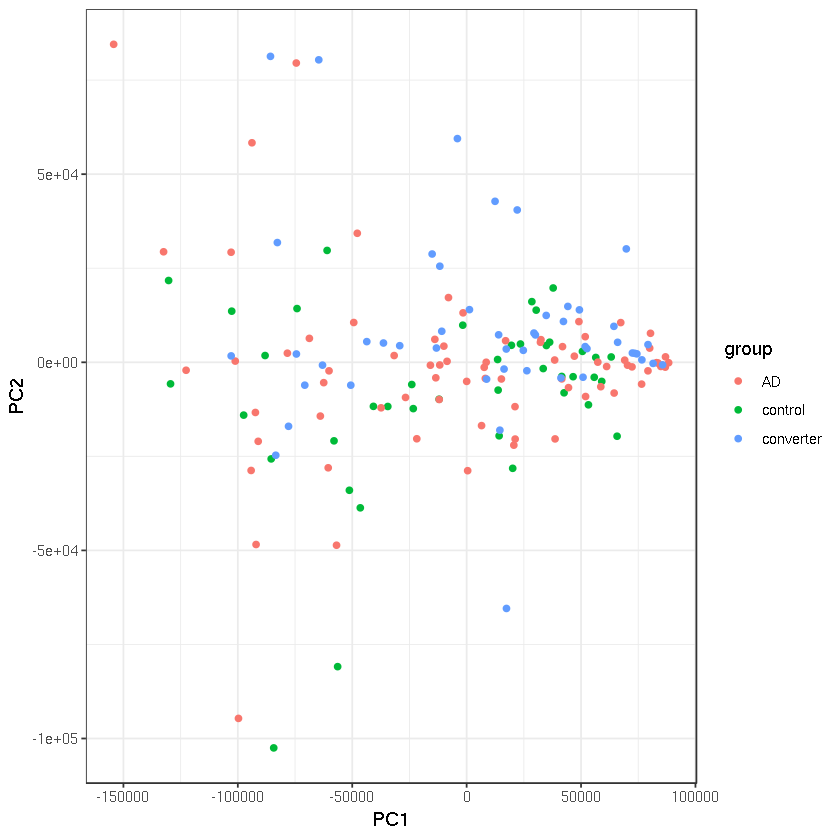

In [11]:
# Plot PCA
pca.dt <- cbind(meta.dt, pca$x)
ggplot(pca.dt, aes(x=PC1, PC2, color = group)) + geom_point() + theme_bw()

## Look into AMP-AD genes

In [33]:
ampgenes <- c("PBXIP1", "MID1IP1", "SLC25A18", "GFAP", "GNA12", "CRTAP", "QDPR", "GPRC5B", "PADI2",
             "NACC2", "RHOQ", "QKI", "CSRP1", "CALD1", "SASH1", "TNS3", "LAMP2", "ERBB2IP", "FAM107A",
             "PLXNB1", "AHNAK", "MYO10", "PDE4DIP", "ITPKB", "KCNJ10", "DOCK1","MRAS","PHGDH")


up.ampgenes <- c( "PADI2","NACC2", "RHOQ", "QKI", "CSRP1", "CALD1", "SASH1", "TNS3", "LAMP2", 
                 "ERBB2IP", "FAM107A","PLXNB1", "AHNAK", "MYO10", "PDE4DIP", "ITPKB", "KCNJ10", 
                 "DOCK1","MRAS","PHGDH")

down.ampgenes <- c("PBXIP1", "MID1IP1", "SLC25A18", "GFAP", "GNA12", "CRTAP", "QDPR", "GPRC5B")


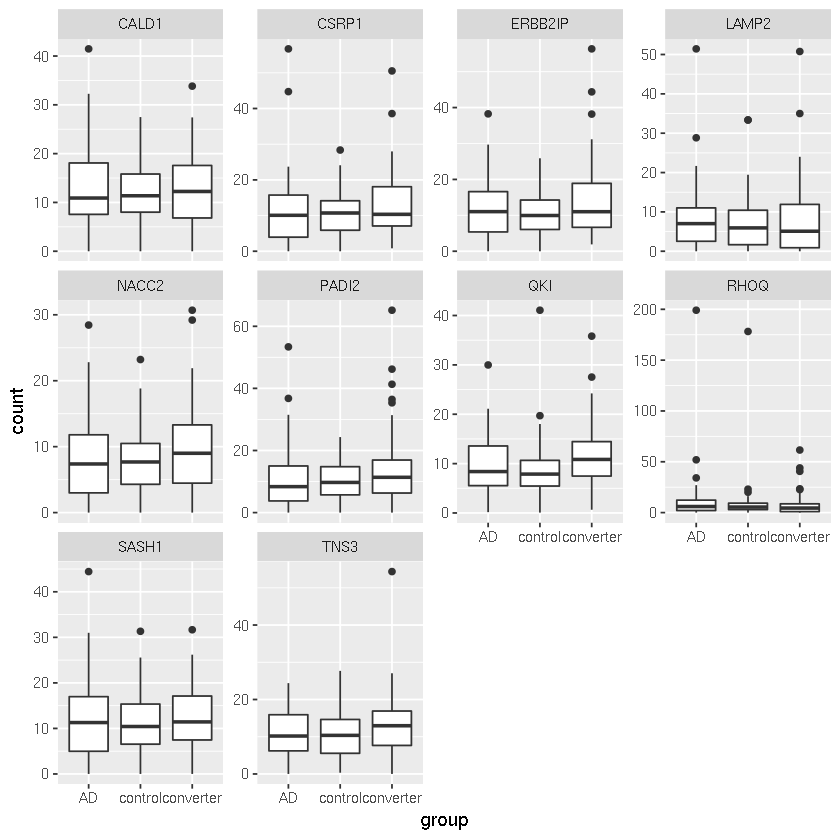

In [52]:
dt <- counts.longdt %>%
    filter(gene_name %in% up.ampgenes[1:10]) 
# dt 

ggplot(dt, aes(x=group, y = count)) + 
    geom_boxplot() + 
    facet_wrap(~gene_name, scales="free_y")

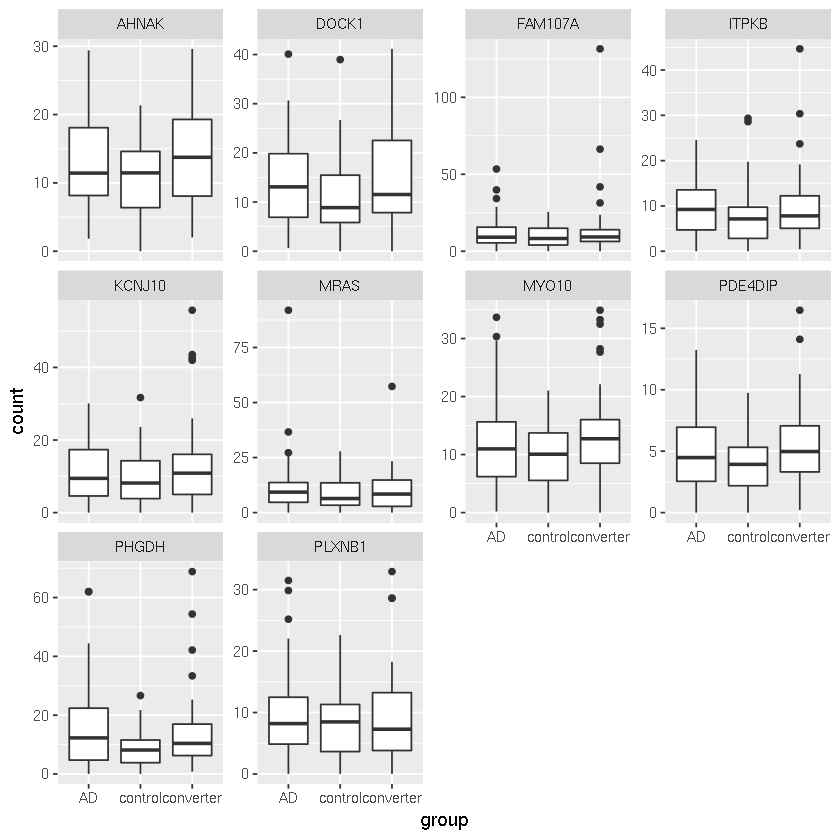

In [54]:
dt <- counts.longdt %>%
    filter(gene_name %in% up.ampgenes[11:20]) 
# dt 

ggplot(dt, aes(x=group, y = count)) + 
    geom_boxplot() + 
    facet_wrap(~gene_name, scales="free_y")
# most AMP - AD genes are also upregulated in this data

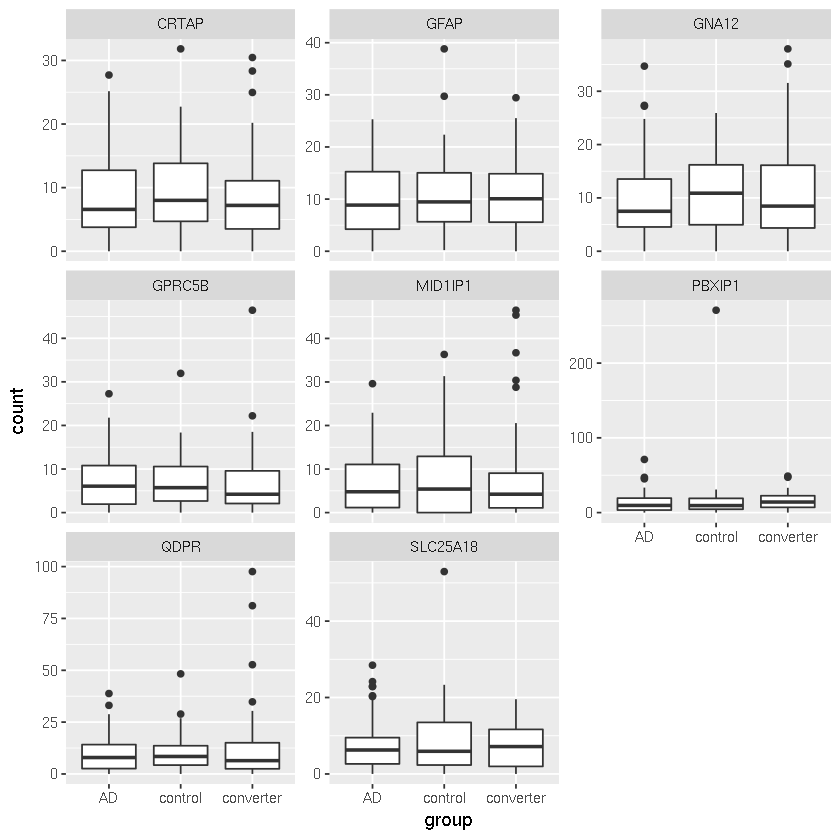

In [63]:
dt <- counts.longdt %>%
    filter(gene_name %in% down.ampgenes) 
# dt 

ggplot(dt, aes(x=group, y = count)) + 
    geom_boxplot() + 
    facet_wrap(~gene_name, scales="free_y")
# only some AMP-AD genes are also downreg in this data

### Look at trends of these AMP-AD genes in converters over time
Not very consistent - may be hard to detect converters

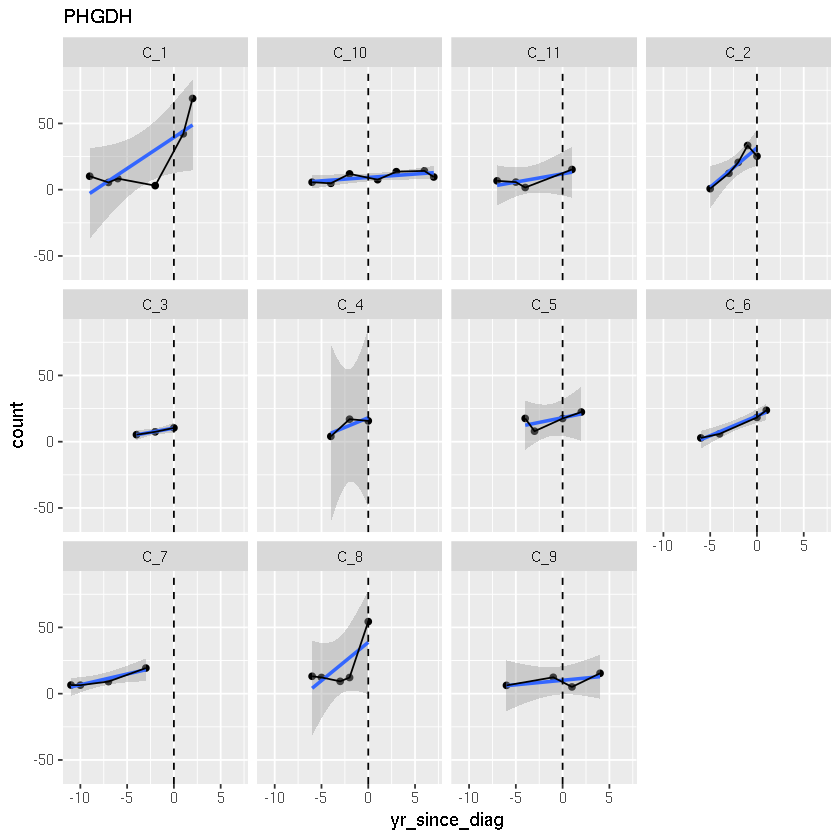

In [76]:
# plot converters for PHGDH
dt <- counts.longdt %>%
    filter(gene_name %in% ampgenes[28], group=="converter")
# dt
ggplot(dt, aes(x=yr_since_diag,y=count)) + geom_point() + geom_smooth(method =  "lm") +
    geom_vline(xintercept = 0, linetype= "dashed") + 
    geom_line() + facet_wrap(~donorID) + ggtitle(ampgenes[28])

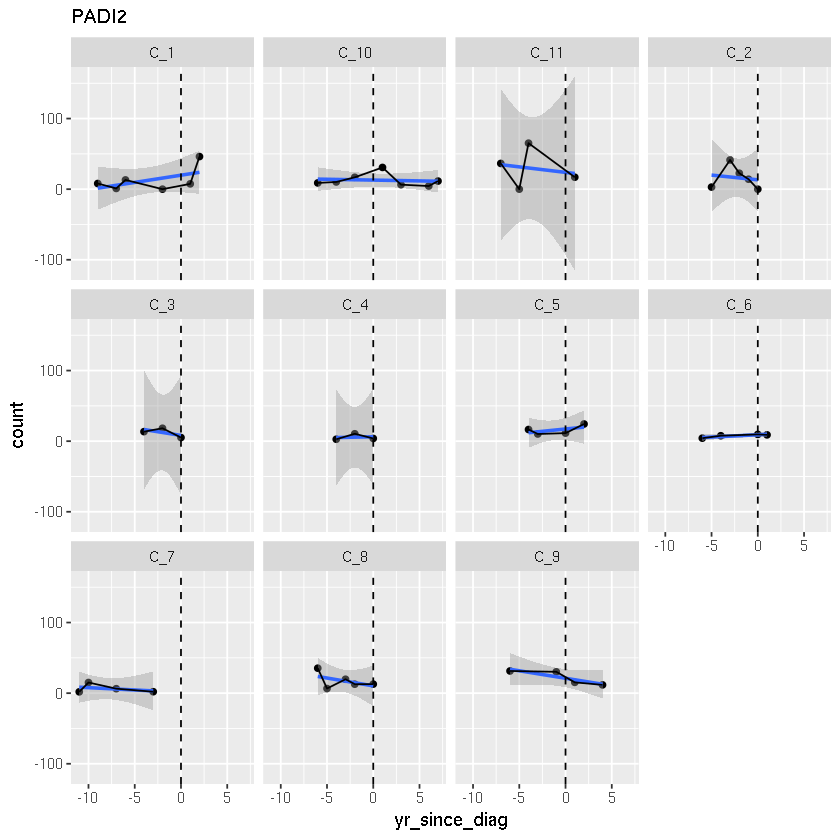

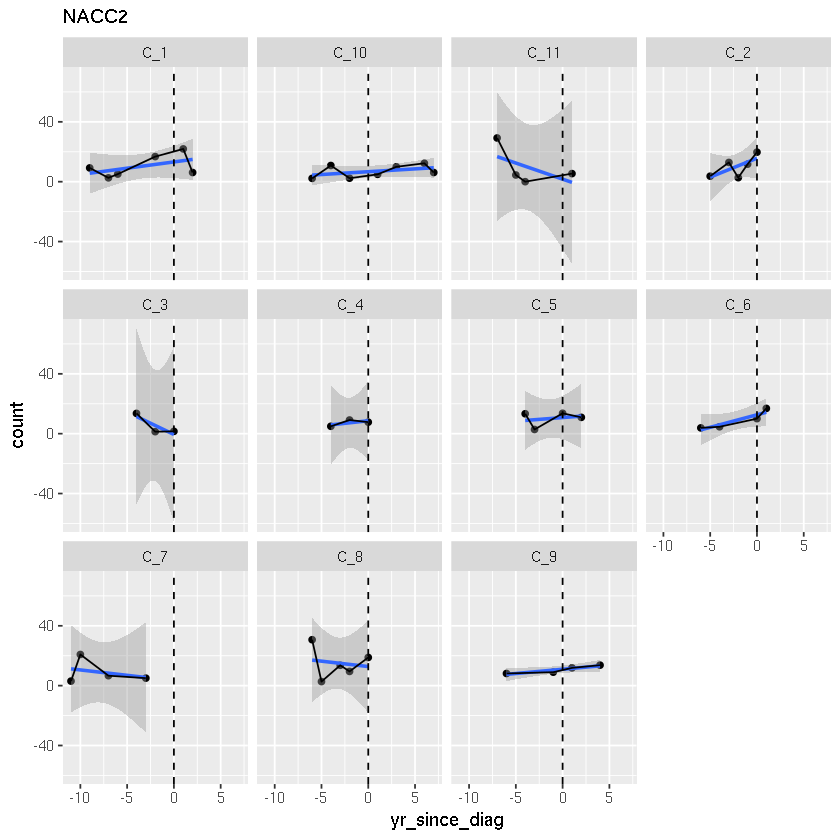

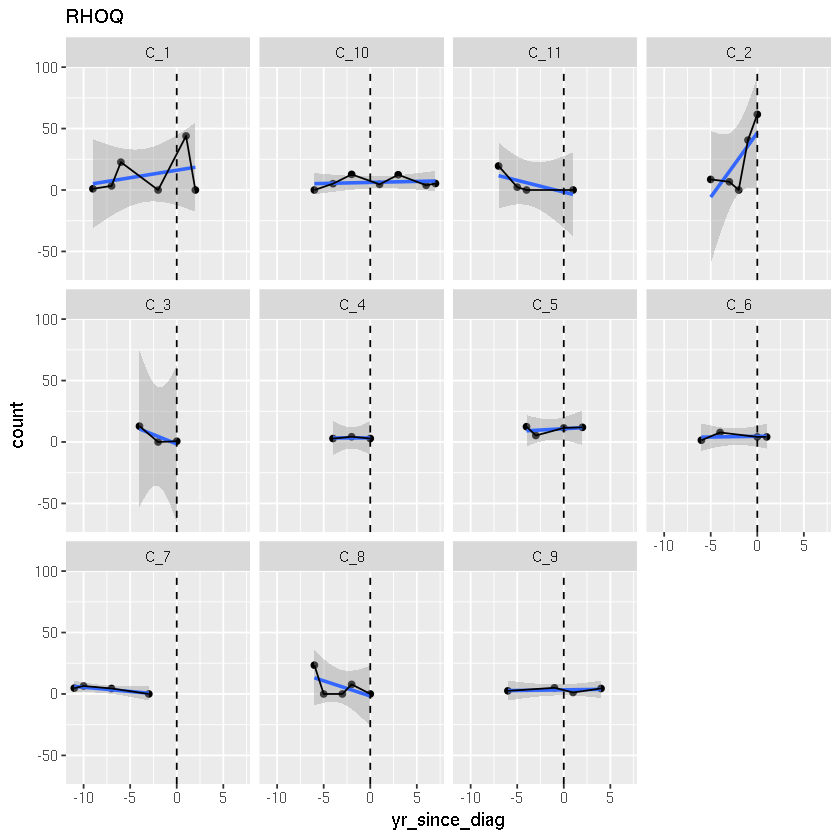

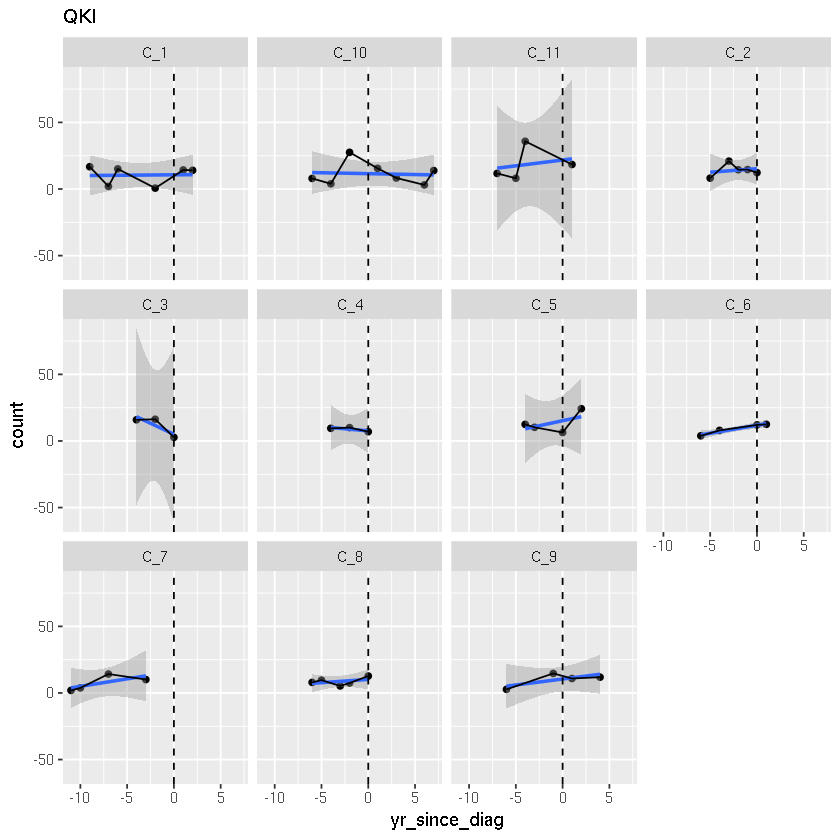

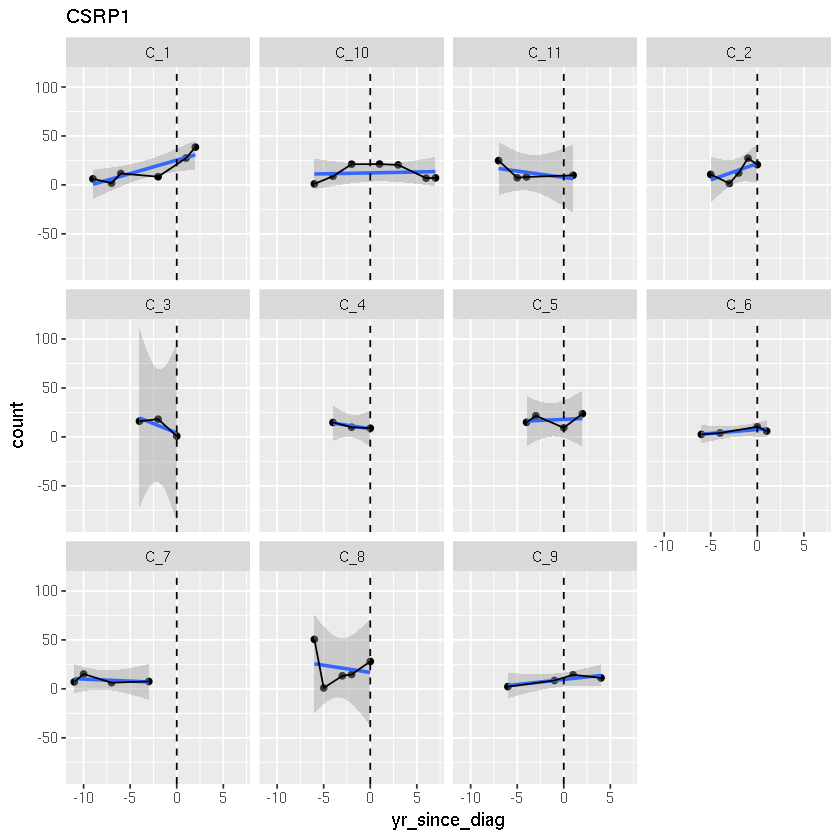

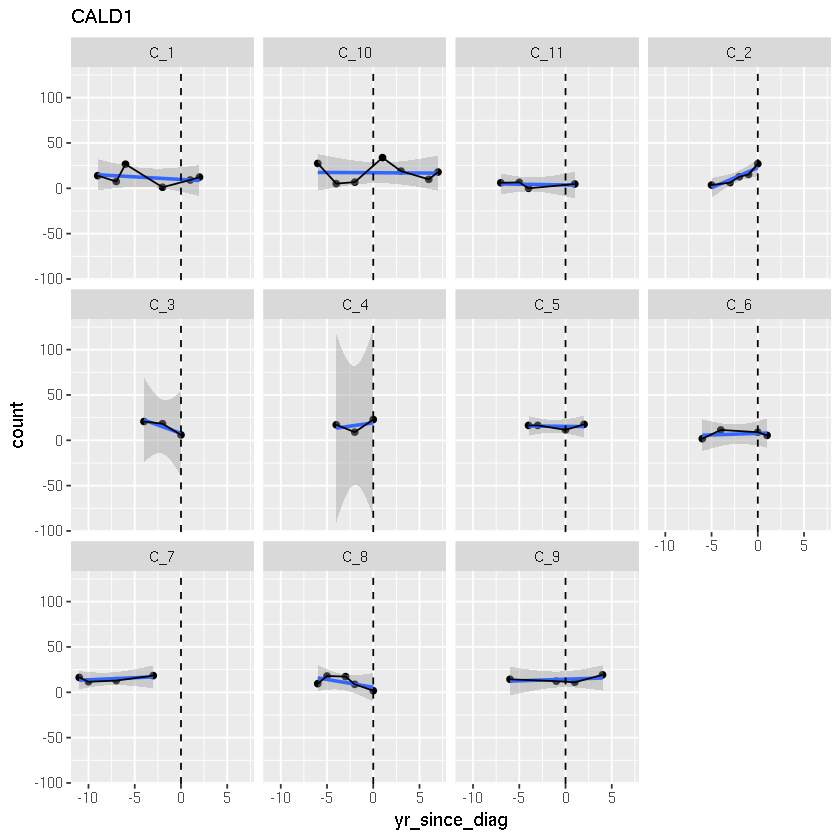

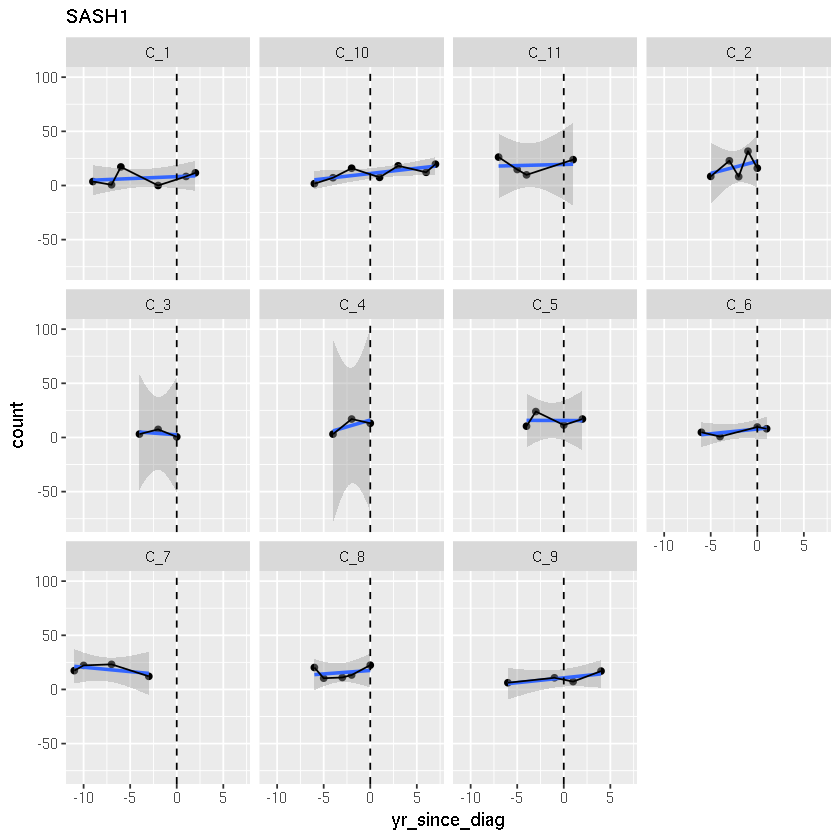

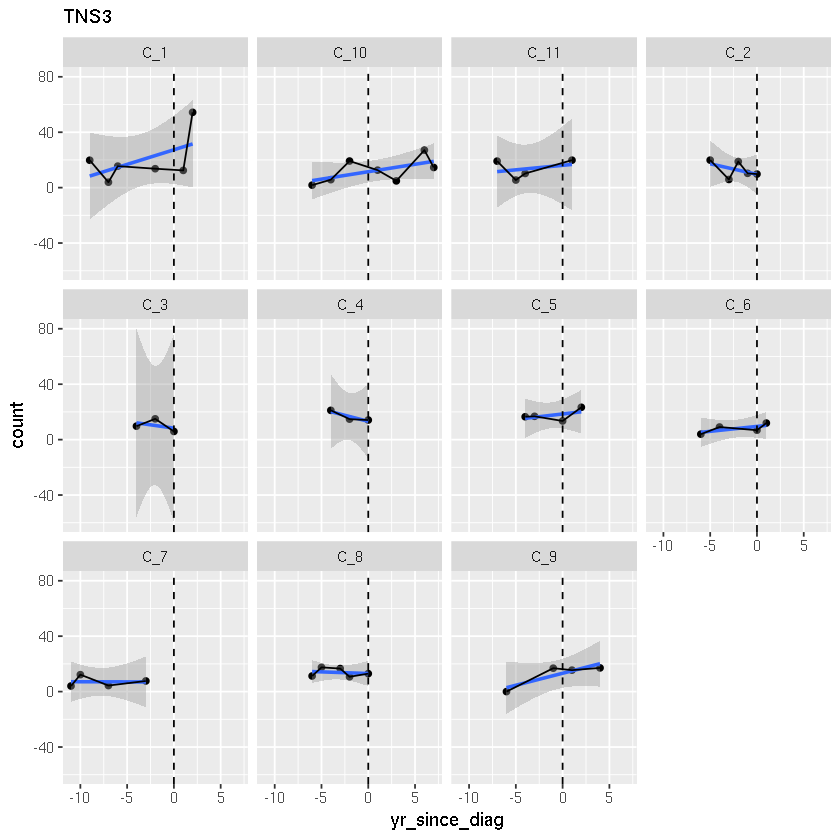

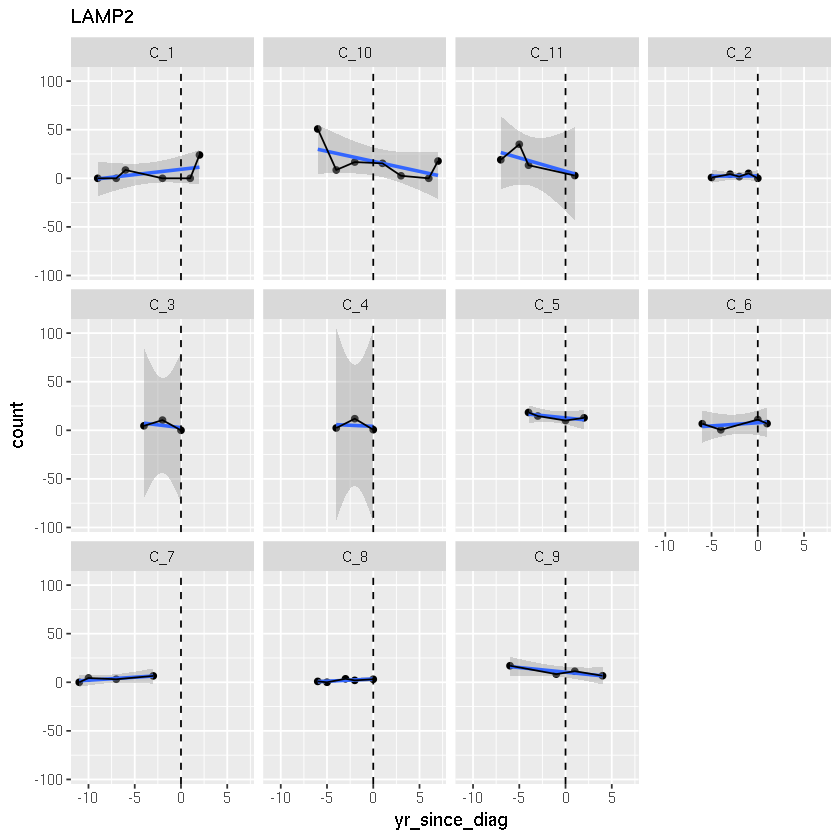

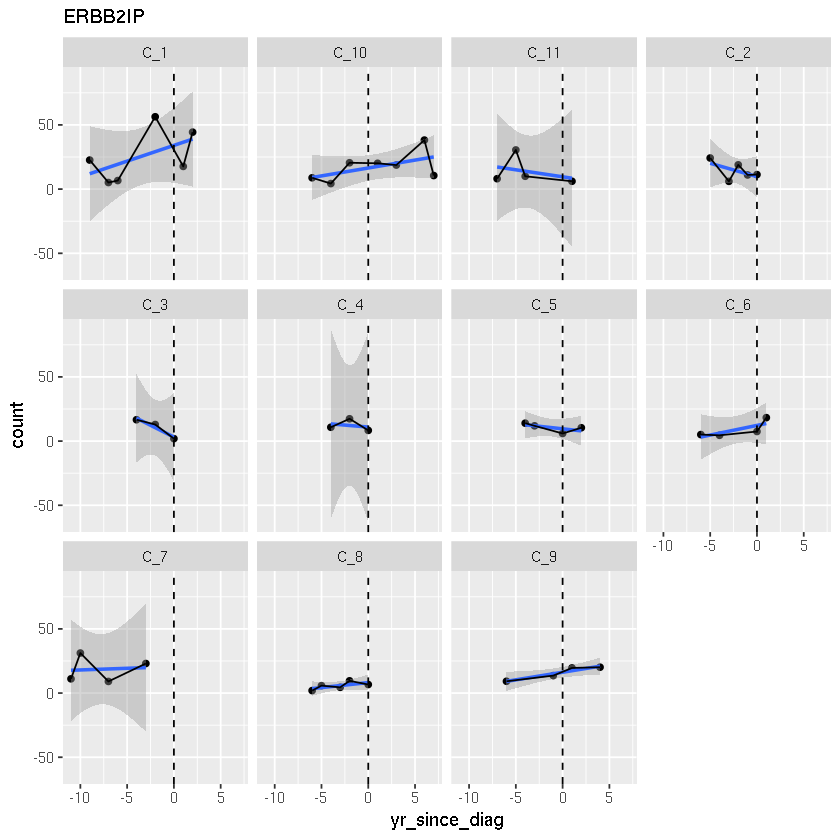

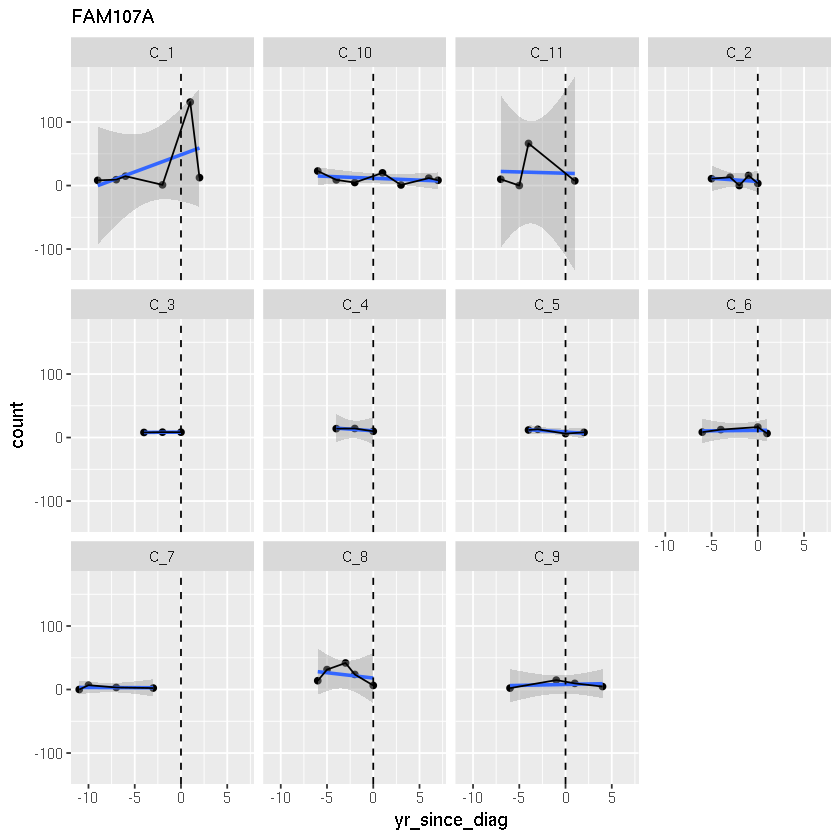

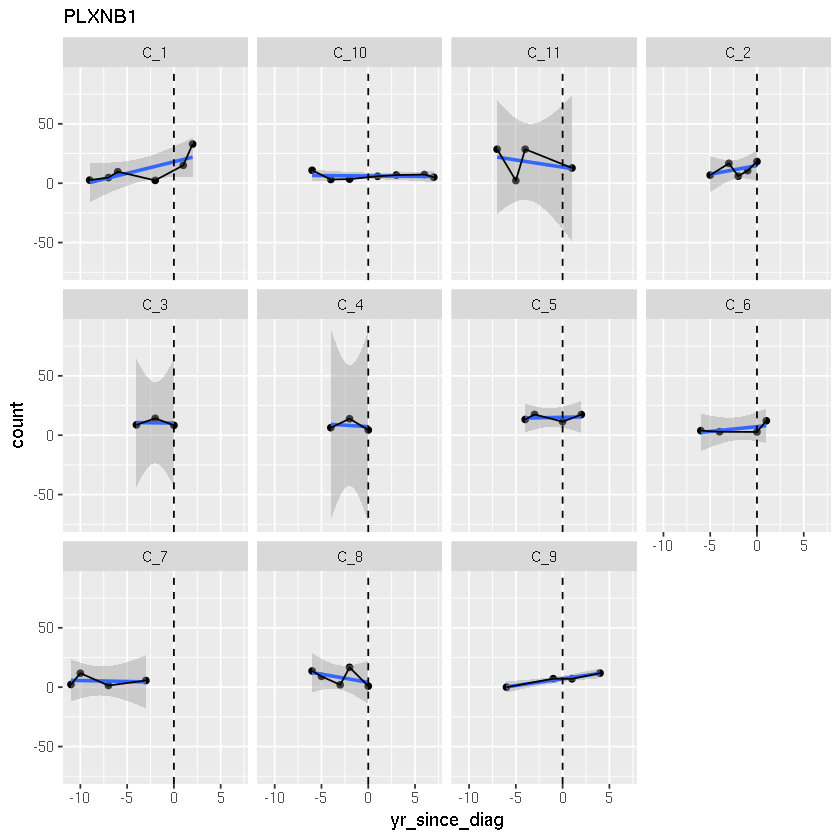

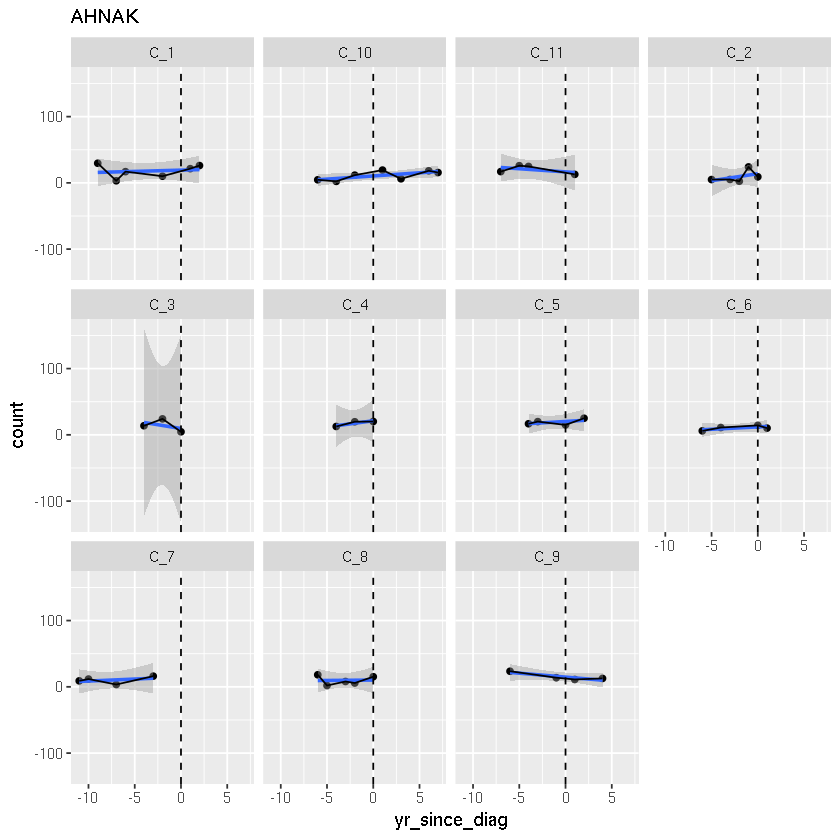

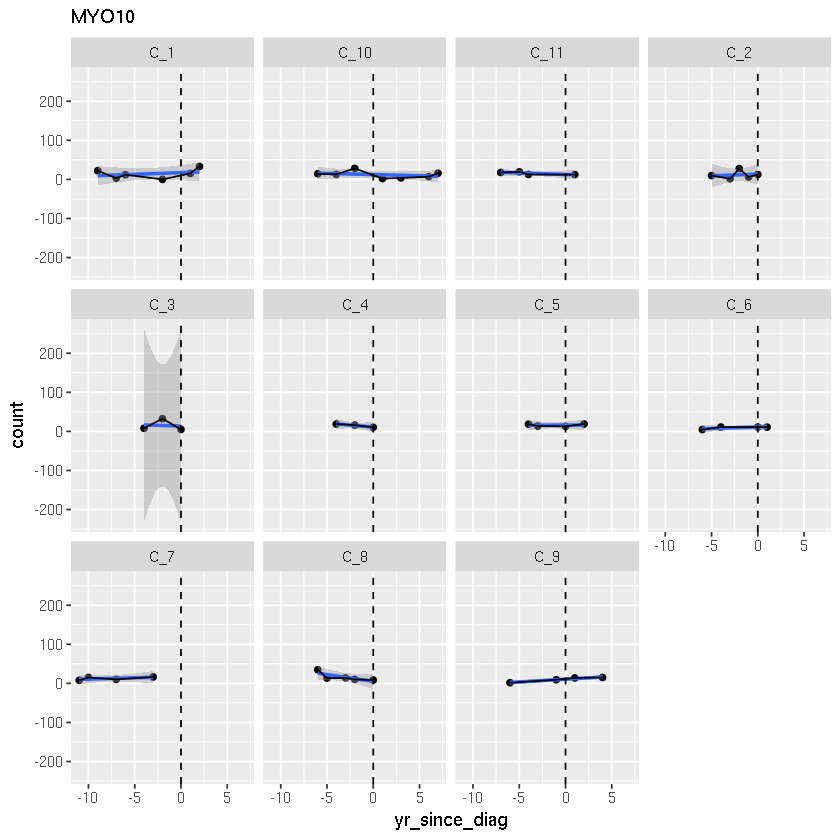

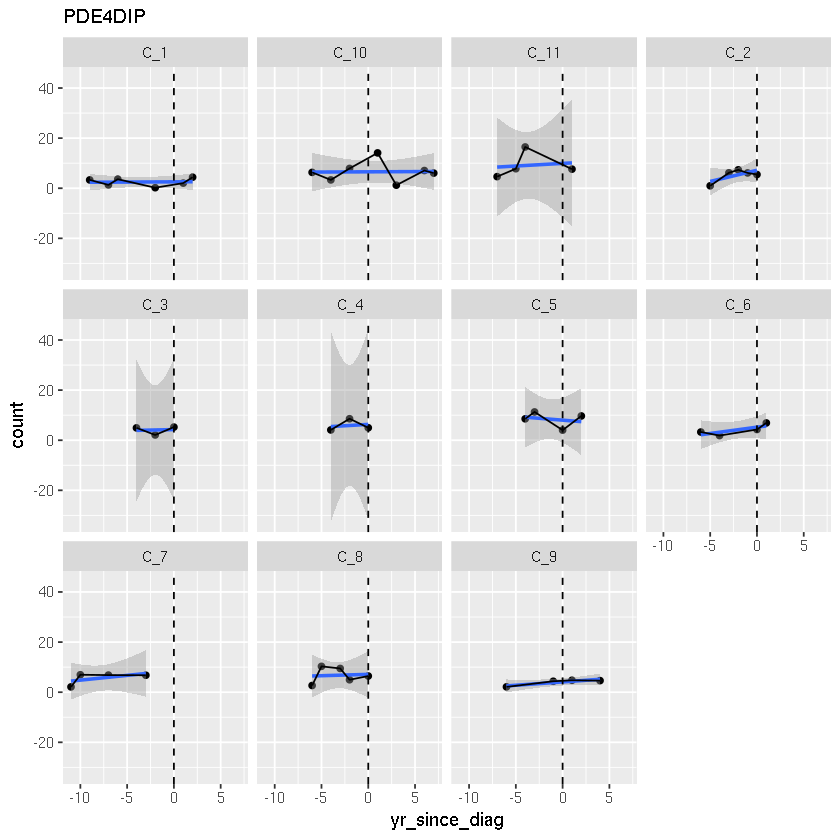

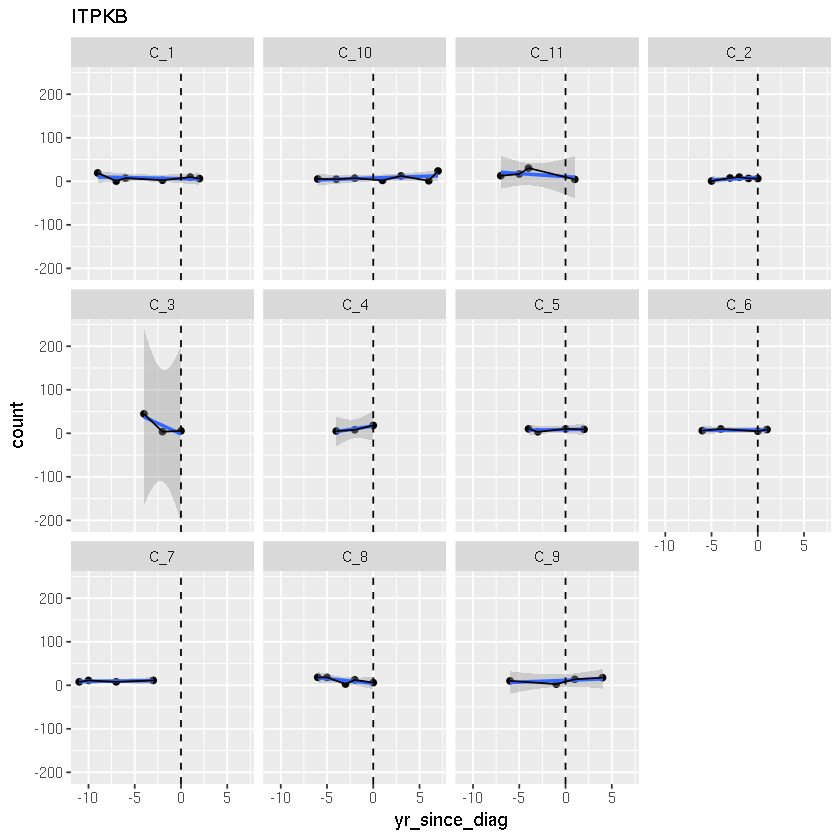

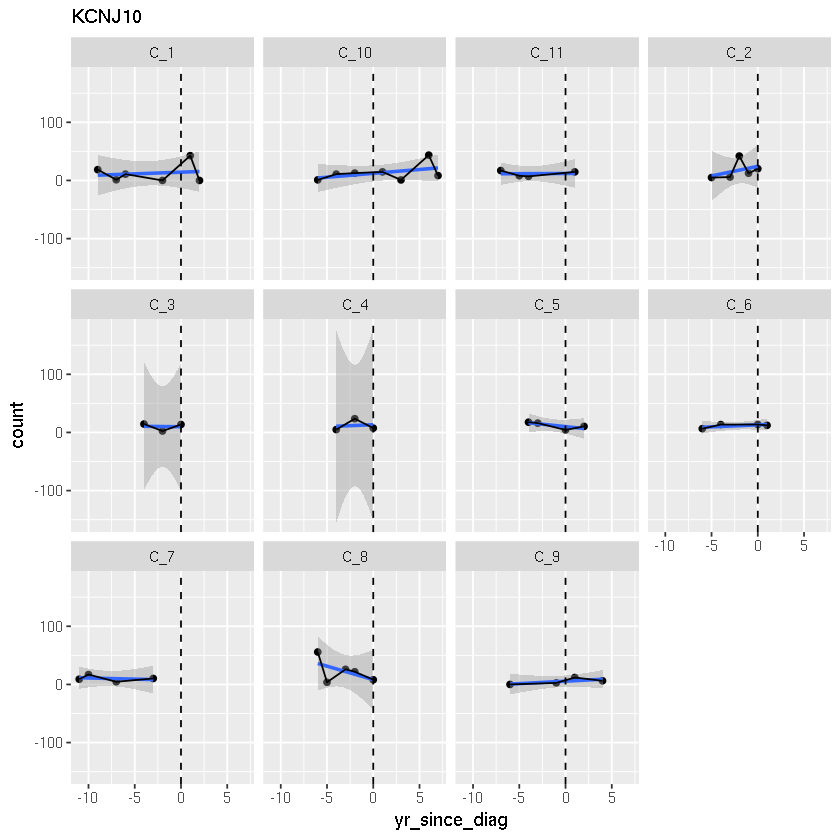

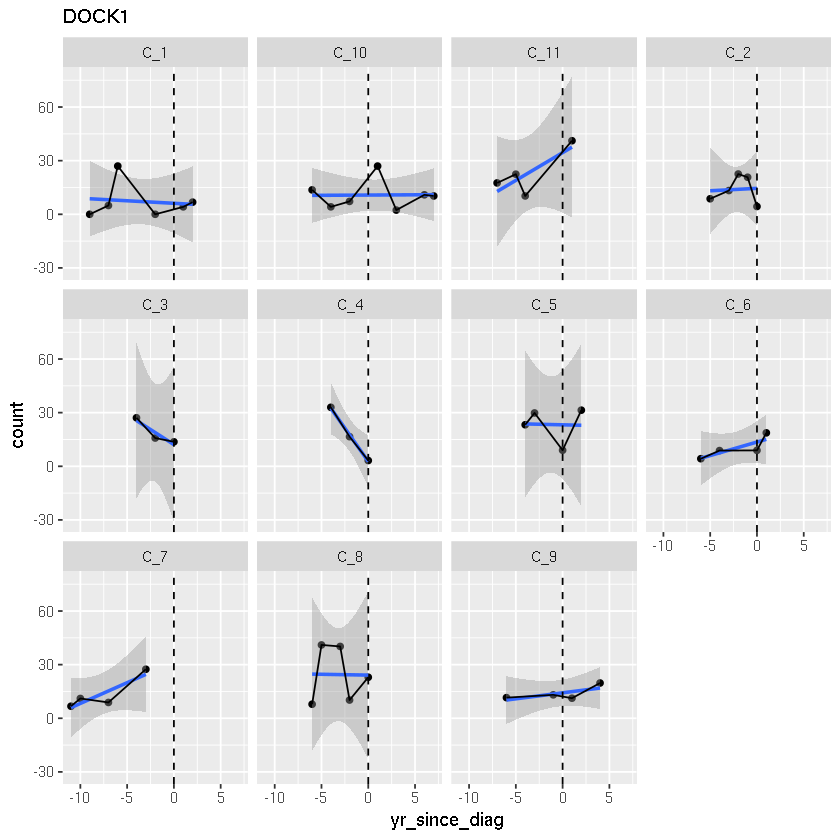

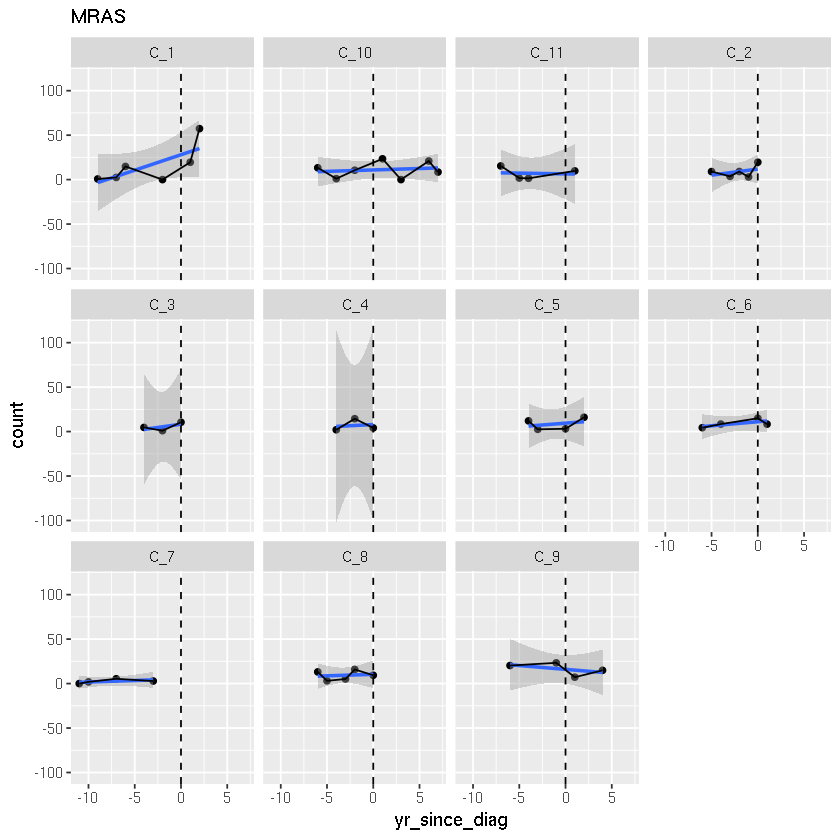

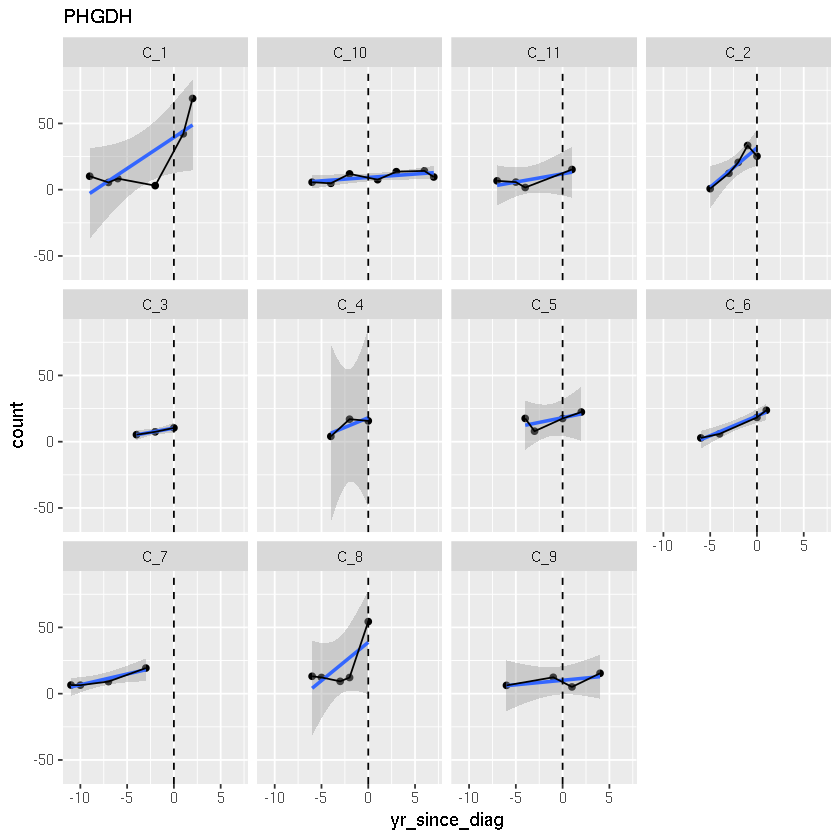

In [106]:
# look at all upregulated genes over time
for (g in up.ampgenes) {
    dt <- counts.longdt %>%
        filter(gene_name %in% g, group=="converter")
    # dt
    show(ggplot(dt, aes(x=yr_since_diag,y=count)) + geom_point() + geom_smooth(method =  "lm") +
        geom_vline(xintercept = 0, linetype= "dashed") + 
        geom_line() + facet_wrap(~donorID) + ggtitle(g))
}
# looks promising

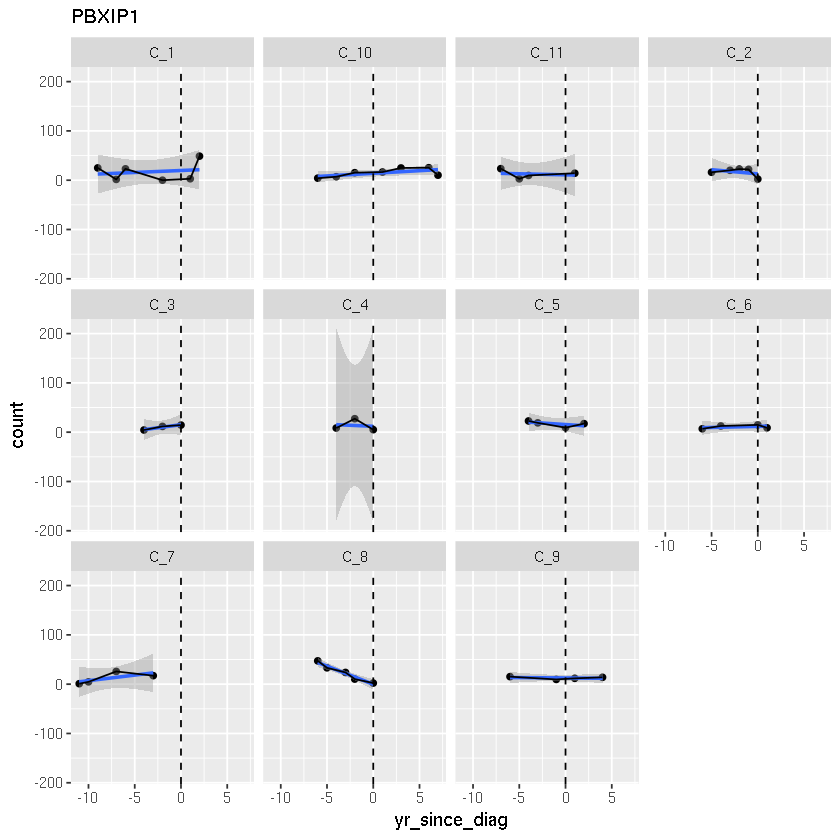

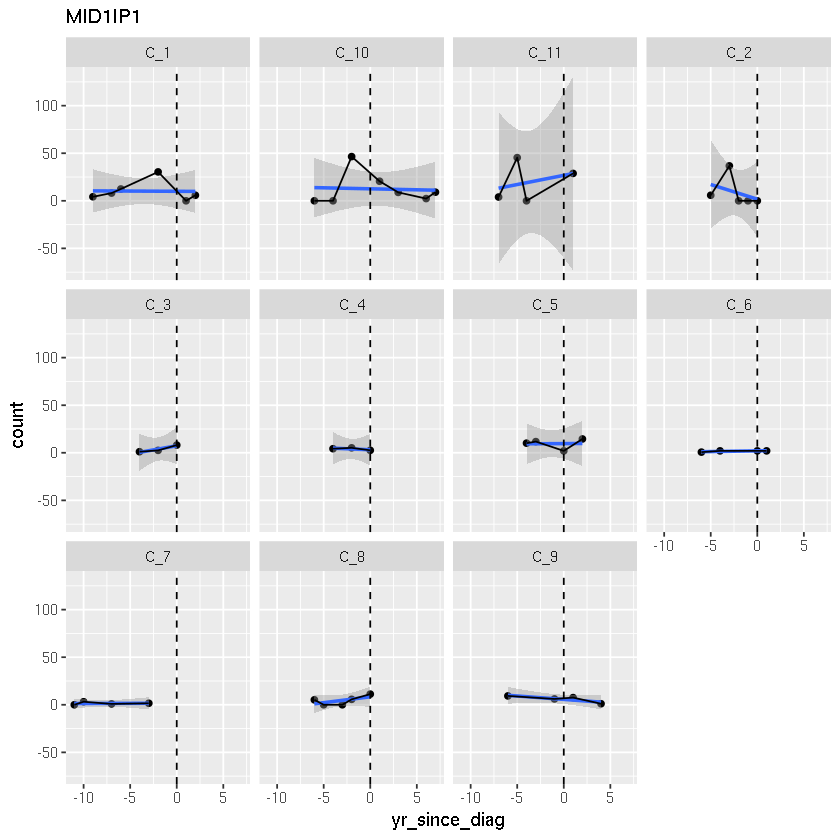

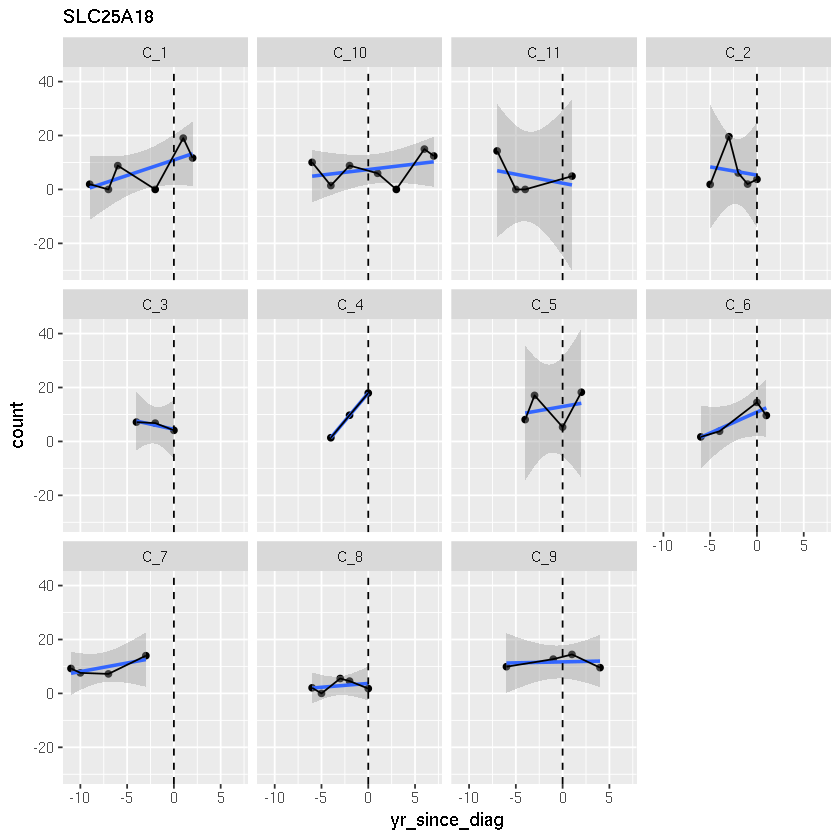

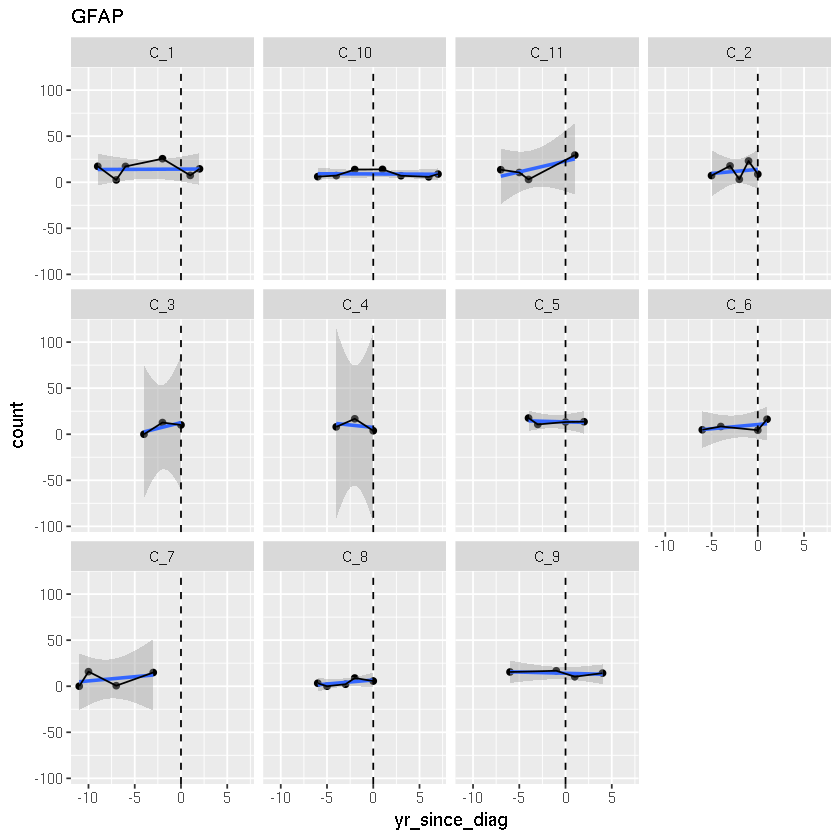

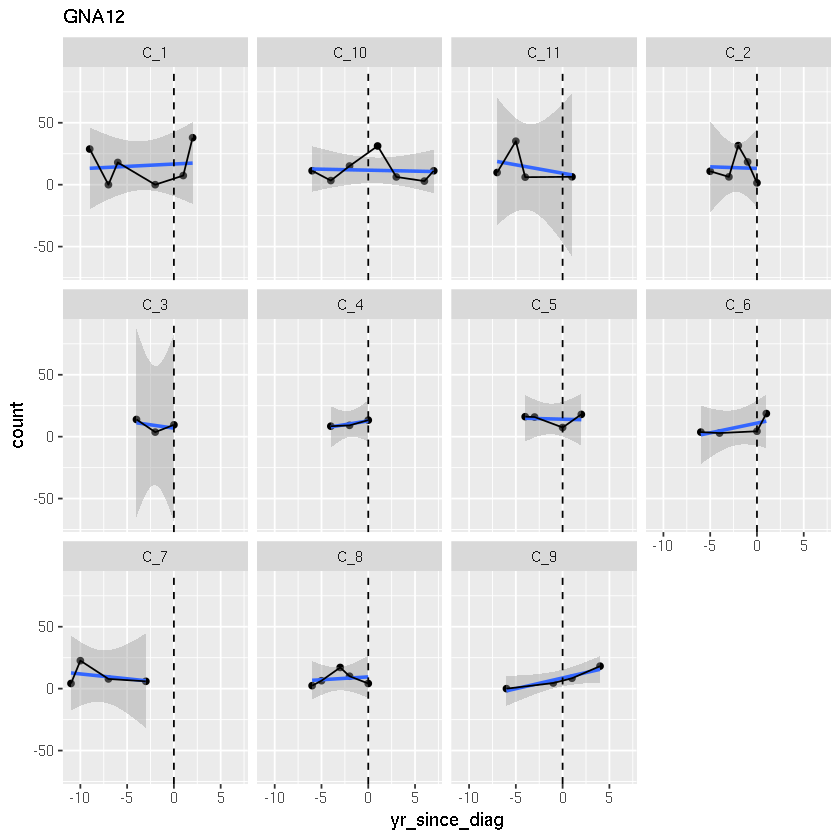

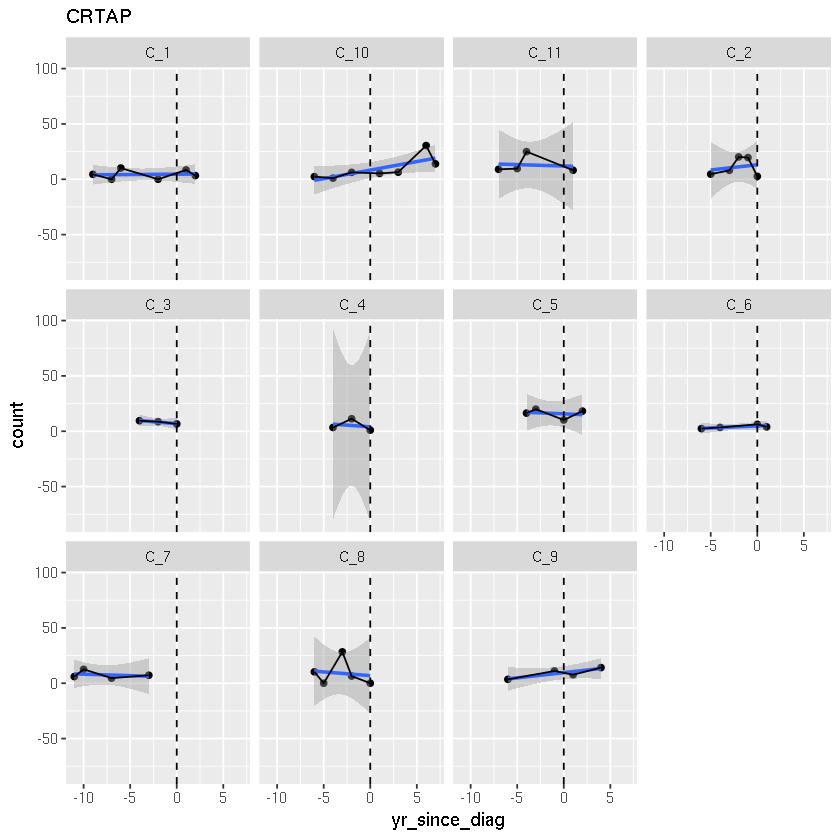

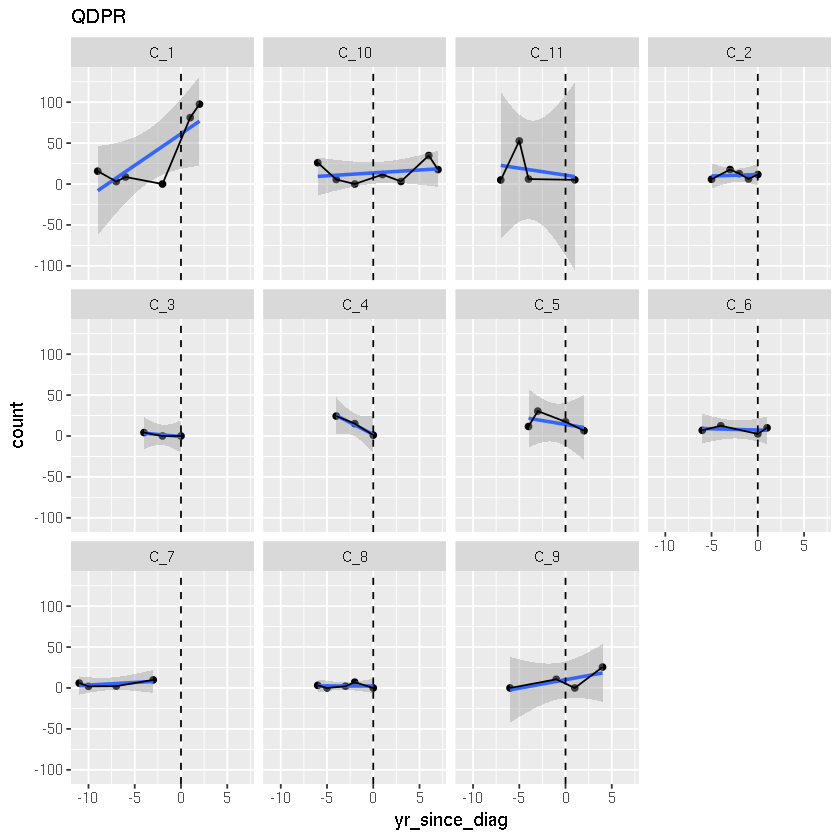

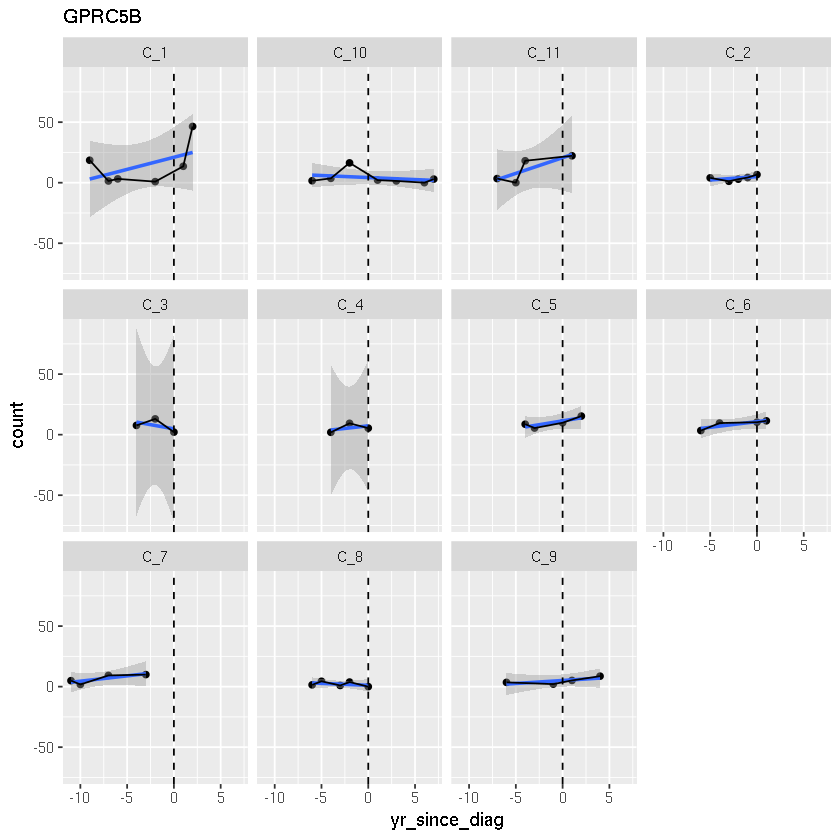

In [78]:
# look at all downregulated genes over time
for (g in down.ampgenes) {
    dt <- counts.longdt %>%
        filter(gene_name %in% g, group=="converter")
    # dt
    show(ggplot(dt, aes(x=yr_since_diag,y=count)) + geom_point() + geom_smooth(method =  "lm") +
        geom_vline(xintercept = 0, linetype= "dashed") + 
        geom_line() + facet_wrap(~donorID) + ggtitle(g))
}
# downreg looks a little less promising

In [ ]:
# may want to remove converters who don't have post diagnosis measurements
rmv <- c("C_2", "C_3", "C_4", "C_7", "C_8")

#### any linear trends in AD patients over time?
None seen from these genes

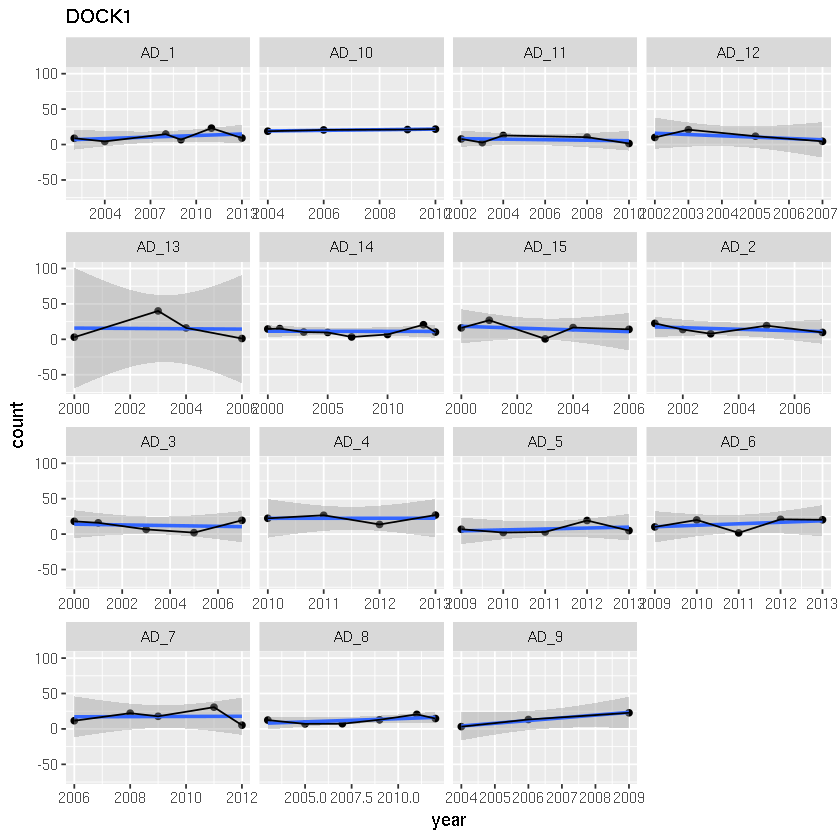

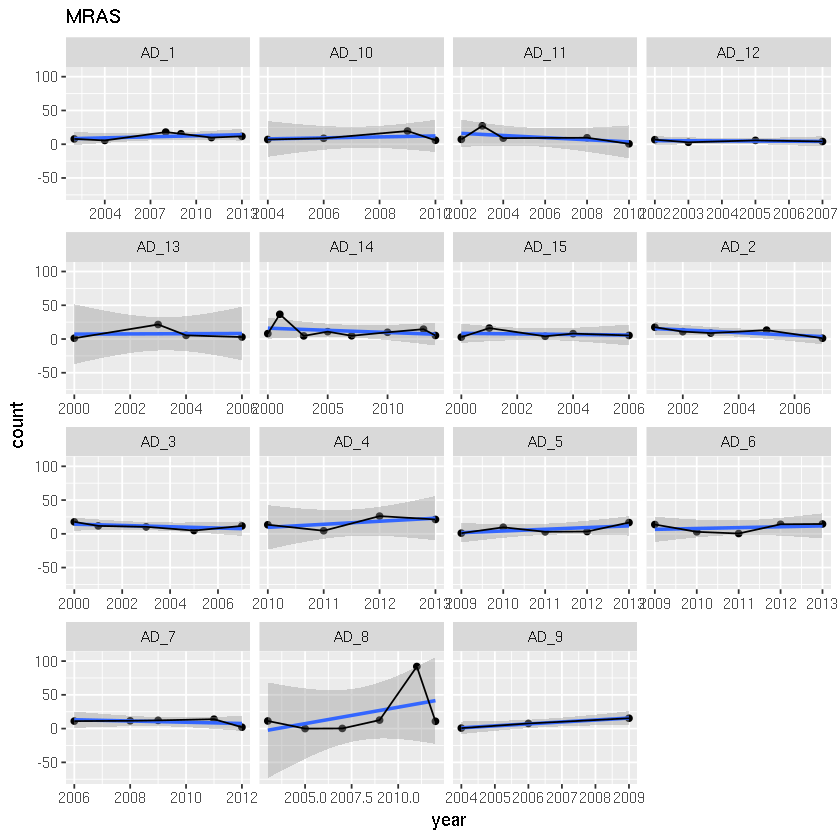

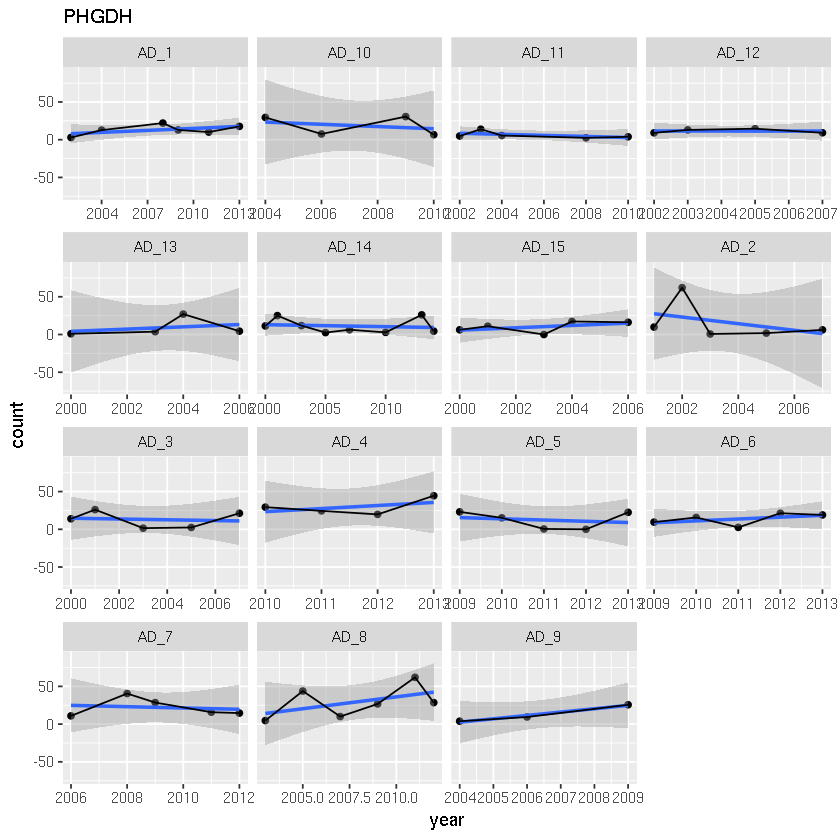

In [118]:
# look at all upregulated genes over time in AD patients to see if there are linear trends
dt <- counts.longdt %>%
    filter(group=="AD")
for (g in up.ampgenes[18:20]) {
    dt1 <- dt %>%
        filter(gene_name %in% g) %>%
        arrange(year)
    # dt
    show(ggplot(dt1, aes(x=year,y=count)) + geom_point() + geom_smooth(method =  "lm") +
        geom_line() + facet_wrap(~donorID,scales="free_x") + ggtitle(g)) 
}

# no trends from AD individuals

In [ ]:
## Look for genes that are linearly correlated in AD but not controls


In [ ]:
# ### Example linear mixed model
# library(lme4)
# lmer(log2(count+1) ~ yr_since_diag + group + sex)

In [ ]:
# ### SVM Script
# library("tidyverse")
# # in case you cannot install tidyverse package, please uncomment the packages below
# # library("readr")
# # library("tibble")
# # library("dplyr")
# # library("tidyr")
# # library("ggplot2")
# library("magrittr")
# library("DESeq")
# library("e1071")
# library("ROCR")

# # load data ---------------------------------------------------------------
# # load the expression level data. TPM and readCoutns, the first row shows the sample ID
# tpm <- read_tsv("data/tpm_96_nodup.tsv", col_names = T)
# readcounts <- read_tsv("data/readcounts_96_nodup.tsv", col_names = T)

# # load sample meta data file
# # the column "sampleID" matchs the colnames of variable tpm and readcounts
# # the column "recurStatus" shows the recurrence status of the patient, R = recurrence, N = non-recurrence 
# patient_info <- read_csv("data/patient_info.csv", col_names = T) # recurrence status file

# # generate sample_recurStatus dataframe with the same sample order in tpm and reacounts
# sampel_recurStatus <- patient_info %>% arrange(match(sampleID, colnames(readcounts)[-1])) %>%
#   select(sampleID, recurStatus)

# # load the pre-selected marker gene list
# preselectedList <- readLines("data/preselectedList") # breast cancer biomarkers

# # differential expression (DE) analysis of the biomarker genes ---------------
# # we use DESeq to calculate the DE p-value of each biomarker gene, 
# # then rank the marker genes by their p-values

# cds <- newCountDataSet(countData = readcounts %>% filter(gene_id %in% preselectedList) %>% column_to_rownames("gene_id"), 
#                        conditions = sampel_recurStatus$recurStatus)
# cds <- estimateSizeFactors(cds)
# cds <- estimateDispersions(cds)
# res <- nbinomTest(cds, "R", "N")
# rank_marker_gene <- res %>% filter(id %in% preselectedList) %>%
#   arrange(pval) %>% .$id

# # calculate and plot Fig5C in PNAS paper ----------------------------------
# # number of gene in biomarker gene sets selected by their rank in rank_marker_gene,
# # top 30, 60, 90, ... 720, 750
# geneNum <- seq(30, 750, 30) 

# # calculate average AUC of SVM based on each subset of biomarker genes 
# # need several minutes to complete the loop

# averageAUC <- rep(0, length(geneNum)) 
# for(i in 1:length(geneNum)){
#   temp.tpm <- tpm %>% filter(gene_id %in% rank_marker_gene[1:geneNum[i]]) %>%
#     column_to_rownames("gene_id") %>% t() %>% as.data.frame() %>%
#     mutate(status = as.factor(ifelse(sampel_recurStatus$recurStatus == "R", 1, 0)))
  
#   idx_pos <- which(temp.tpm$status == 1)
#   idx_neg <- which(temp.tpm$status == 0)
  
#   set.seed(123) # seed for random number, for reproducible results
  
#   # random sampling of trainging and testing dataset, 100 times average auc
#   auc <- sapply(1:100, FUN = function(x){
#     # trainning set 20 pos vs 20 neg, test set 8 pos vs 48 neg
#     idx_testset <- c(sample(idx_pos, 8),sample(idx_neg, 48))
    
#     testset <- temp.tpm[idx_testset, ]
#     trainset <- temp.tpm[-idx_testset, ]
    
#     idx_zero_train <- which(colSums(trainset[, -ncol(trainset)]) == 0)
#     if(length(idx_zero_train) > 0){
#       trainset <- trainset[, -idx_zero_train]
#       testset <- testset[, -idx_zero_train]
#     }

#     # use svm function in e1071 package to train SVM model,
#     # and then use ROCR function to calculate ROC curve data and auc
#     svm.model <- svm(status ~ ., data = trainset, cost = 5, kernel = 'sigmoid')
#     svm.pred <- predict(svm.model, testset[, -ncol(testset)], decision.values = T)
#     pred <- prediction(attr(svm.pred, "decision.values"), testset$status)
#     perf_auc <- as.numeric(performance(pred, "auc")@y.values)

#     return(perf_auc)
#   })
  
#   averageAUC[i] <- mean(auc)
# }

# # plot the number of biomarker against average AUC plot (Fig 5C)

# data.frame(geneNum = geneNum, averageAUC = averageAUC) %>%
#   ggplot(aes(x = geneNum, y = averageAUC)) +
#   geom_point(shape=16, color = 'red',size=1.2) + 
#   scale_y_continuous(limits = 0:1) +
#   theme(plot.background = element_rect(fill = 'white', colour = 'grey',linetype = 'solid'),
#         panel.background = element_rect(fill = 'white',color = 'grey',size=0.75,linetype='solid'),
#         panel.grid.major = element_line(colour = "grey",size=0.2),
#         panel.border = element_rect(colour = "grey", fill=NA, size=0.75)) +
#   labs(x = 'Number of genes', y = 'Average AUC',fill = '') + 
#   theme(axis.text.x = element_text(size=8,hjust = 1),axis.text.y = element_text(size=8),
#         axis.title.y = element_text(size=11),axis.title.x = element_text(size=11),
#         legend.text = element_text(size = 8)) 
# ggsave('averageAUC.pdf', width = 4, height = 4)


# # select top 215 biomarker genes to plot Fig 5D ---------------------------

# temp.tpm <- tpm %>% filter(gene_id %in% rank_marker_gene[1:215]) %>%
#   column_to_rownames("gene_id") %>% t() %>% as.data.frame() %>%
#   mutate(status = as.factor(ifelse(sampel_recurStatus$recurStatus == "R", 1, 0)))

# idx_pos <- which(temp.tpm$status == 1)
# idx_neg <- which(temp.tpm$status == 0)

# set.seed(123)
# # random sampling of trainging and testing dataset, 3 times

# roc_data <- c()
# auc <- c()
# for(i in 1:3){
#   idx_testset <- c(sample(idx_pos, 8),sample(idx_neg, 48))
  
#   testset <- temp.tpm[idx_testset, ]
#   trainset <- temp.tpm[-idx_testset, ]
  
#   idx_zero_train <- which(colSums(trainset[, -ncol(trainset)]) == 0)
#   if(length(idx_zero_train) > 0){
#     trainset <- trainset[, -idx_zero_train]
#     testset <- testset[, -idx_zero_train]
#   }
  
#   # use svm function in e1071 package to train SVM model,
#   # and then use ROCR function to calculate ROC curve data and auc
#   svm.model <- svm(status ~ ., data = trainset, cost = 5, kernel = 'sigmoid')
#   svm.pred <- predict(svm.model, testset[, -ncol(testset)], decision.values = T)
#   pred <- prediction(attr(svm.pred, "decision.values"), testset$status)
#   perf_roc <- performance(pred, "tpr", "fpr")
#   roc_data <- rbind(roc_data, 
#                     data.frame(runtime = as.factor(i), 
#                                x = perf_roc@x.values[[1]], 
#                                y = perf_roc@y.values[[1]]))
#   perf_auc <- performance(pred, "auc")
#   auc <- c(auc, as.numeric(perf_auc@y.values))
  
# }

# # plot roc curves from randomly generated roc_data

# ggplot(roc_data, aes(x = x, y = y, group = runtime, col = runtime)) + geom_line() +
#   labs(x = '1 - Specificity', y = 'Sensitivity',fill = '') +
#   theme(plot.background = element_rect(fill = 'white', colour = 'grey',linetype = 'solid'),
#         panel.background = element_rect(fill = 'white',color = 'grey',size=0.75,linetype='solid'),
#         panel.grid.major = element_line(colour = "grey",size=0.2),
#         panel.border = element_rect(colour = "grey", fill=NA, size=0.75)) +
#   theme(axis.text.x = element_text(size=8,hjust = 1),axis.text.y = element_text(size=8),
#         axis.title.y = element_text(size=11),axis.title.x = element_text(size=11),
#         legend.position = "none") +
#   scale_y_continuous(limits = 0:1) +
#   scale_x_continuous(limits = 0:1) +
#   annotate('text',label = paste0('Average AUC = ',format(round(mean(auc), 2), nsmall = 3)), 
#            x = 0.65, y=0.2, size = 3)

# ggsave('ROCplot.pdf', width = 4, height = 4)
# column_to_rownames()
